# Julia ecosystems of scientific computing

This last session gives a (**very brief**) overview of some powerful Julia packages I found useful and/or interesting.


# 1. DifferentialEquations.jl

[DifferentialEquations.jl](https://github.com/SciML/DifferentialEquations.jl) is by far [the best](https://www.stochasticlifestyle.com/comparison-differential-equation-solver-suites-matlab-r-julia-python-c-fortran/) free and open source differential equations solver (not for Julia, for any language). It can solve standard ODEs, Delay-DEs, stochastic DEs, has tools for PDEs, event handling, other multiple features, 100s of solvers, and *even more*.

Here we will focus on ODEs and use the module `OrdinaryDiffEq` only.

## Defining and solving some ODEs

The way DifferentialEquations.jl works is quite straightforward:

1. Make your set of ODEs a Julia function `f`
2. Put `f`, an initial state and a parameter container into an `ODEProblem`.
2. Choose the solvers and the arguments of the solvers you will use (e.g. tolerances, etc.)
3. Give `f` as well as the auxiliary arguments to the function `solve`!

Let's see it in practice by solving the Lorenz system

$$
\begin{aligned}
\dot{x} &= \sigma (y - x) \\
\dot{y} &= x (\rho - z) - y \\
\dot{z} &= xy -\beta z
\end{aligned}
$$

In [1]:
using OrdinaryDiffEq, StaticArrays

function lorenz_rule(u, p, t)
    σ, ρ, β = p
    x, y, z = u
    dx = σ*(y - x)
    dy = x*(ρ-z) - y
    dz = x*y - β*z
    return SVector(dx, dy, dz)
end

lorenz_rule (generic function with 1 method)

Then set the initial state and parameter container

In [2]:
u₀ = SVector(10.0, 10.0, 10.0)
p₀ = [10, 28, 8/3]

3-element Vector{Float64}:
 10.0
 28.0
  2.6666666666666665

then put everything into the `ODEProblem` structure:

In [3]:
# third argument is the timespan to solve in
prob = ODEProblem(lorenz_rule, u₀, (0.0, 100.0), p₀)

ODEProblem with uType SVector{3, Float64} and tType Float64. In-place: false
timespan: (0.0, 100.0)
u0: 3-element SVector{3, Float64} with indices SOneTo(3):
 10.0
 10.0
 10.0

Alright, so now we choose the solver to use

In [4]:
alg = Vern9() # 9-th order adaptive solver

Vern9(stage_limiter! = trivial_limiter!, step_limiter! = trivial_limiter!, thread = static(false), lazy = true)

Now let's solve the Lorenz system using the default settings of DifferentialEquations.jl (without specifying anything else).

In [5]:
sol = solve(prob; alg = alg)

retcode: Success
Interpolation: specialized 9th order lazy interpolation
t: 896-element Vector{Float64}:
   0.0
   0.09355226310426
   0.1728394373814634
   0.24997045873484372
   0.3311160955202647
   0.4274313007963378
   0.5201140753128073
   0.624260479390237
   0.734005218372606
   0.838014934102812
   ⋮
  99.05282966917464
  99.18702153609081
  99.30690376797114
  99.43893318653588
  99.55816051975006
  99.68435188917374
  99.83813557719783
  99.94796125447208
 100.0
u: 896-element Vector{SVector{3, Float64}}:
 [10.0, 10.0, 10.0]
 [14.527288897352582, 21.12071452189923, 24.655401013820832]
 [16.260683890272713, 11.987742957503155, 40.86665186055775]
 [9.41045191317899, -1.3453431666535787, 37.61301670747774]
 [2.332878201363789, -3.8203155271896456, 29.11993717325519]
 [-1.3637305317898103, -3.620012876938611, 22.487559137134788]
 [-3.079359520246503, -4.909410924205444, 18.353583699359536]
 [-5.653730181616077, -9.030462458962507, 16.635620359160434]
 [-10.553561266332451, -15.6

Okay, so what is the returned result? We didn't specify when to save or anything...

The solver we chose, `Vern9` (also true for the default solver) is an adaptive step solver. The system is evolved with adaptive step, until we reach the end of the time span. A state is recorded at every step. E.g. the solution at the third step is 

In [6]:
(sol.t[3], sol.u[3])

(0.1728394373814634, [16.260683890272713, 11.987742957503155, 40.86665186055775])

And using the syntax `sol[i, j]` we can access the `i` variable at the `j`-th time point

In [7]:
sol[1, 3]

16.260683890272713

In [8]:
using Plots
gr()
plot(
    sol[1, :], sol[2, :], sol[3, :],
    legend=false,
    axis=false,
    grid=false
)

Because of the mechanics of the solver, `sol` object allows arbitrary interpolation in time by saving some extra derivative-related numbers. This means that we can use `sol` as a function of time, `sol(t)`:

In [9]:
sol(5.6)

3-element SVector{3, Float64} with indices SOneTo(3):
  0.8157363803134668
 -2.6297520728179724
 25.43130552593611

In [10]:
t = 0:0.01:10
X, Y, Z = zero(t), zero(t), zero(t)
for (i, τ) in enumerate(t)
    X[i], Y[i], Z[i] = sol(τ)
end
plot(X, Y, Z,
    legend=false,
    axis=false,
    grid=false
)

Notice that it is possible to skip this advanced feature of interpolation (and thus also skip collecting the extra interpolation-related numbers) and only save at some pre-defined time points by passing the extra argument `saveat = [points I want]`.

# 2. DynamicalSystems.jl
[DynamicalSystems.jl](https://juliadynamics.github.io/DynamicalSystems.jl/dev/) is an award-winning library for nonlinear dynamics and chaos. 

Around 1/3 of the functionality of DynamicalSystems.jl treats systems with known rule $f$, and directly uses this rule to evolve the state space and the tangent space (the linearized dynamics). DynamicalSystems.jl builds on top of DifferentialEquations.jl to evolve systems in time. The rest of the functionality treats timeseries directly, doesn't matter where you got em from.

## Using known rule $f$

If you have a dynamical system where you know its rule $f$, there are a lot of things you can do with in DynamicalSystems.jl. But for all of them, step 1 is to make this rule $f$ into a `DynamicalSystem` instance. The process here is almost identical to DifferentialEquations.jl:

1. Make $f$ a Julia function (using the same syntax as in DifferentialEquations.jl).
2. Choose initial state and parameter container (again same as DiffEq).
3. Pass these arguments to the `ContinuousDynamicalSystem` constructor (or `DiscreteDynamicalSystem`, for discrete systems).

Here we already have `lorenz_rule, u₀, p₀` defined, so the process  is kind of trivial:

In [11]:
using DynamicalSystems
lorenz = CoupledODEs(lorenz_rule, u₀, p₀)

ERROR: 

LoadError: 

ArgumentError: Package Term [22787eb5-b846-44ae-b979-8e399b8463ab] is required but does not seem to be installed:
 - Run `Pkg.instantiate()` to install all recorded dependencies.

Stacktrace:
 [1] _require(pkg::

Base.PkgId, env::String)
   @ Base ./loading.jl:1739
 [2] _require_prelocked(uuidkey::Base.PkgId, env::String)
   @ Base ./loading.jl:1625
 [3] macro expansion
   @ ./loading.jl:1613 [inlined]
 [4] macro expansion
   @ ./lock.jl:267 [inlined]
 [5] require(into::Module, mod::Symbol)
   @ Base ./loading.jl:1576
 [6] include
   @ ./Base.jl:457 [inlined]
 [7] include_package_for_output(pkg::Base.PkgId, input::String, depot_path::Vector{String}, dl_load_path::Vector{String}, load_path::Vector{String}, concrete_deps::Vector{Pair{Base.PkgId, UInt128}}, source::String)
   @ Base ./loading.jl:2010
 [8] top-level scope
   @ stdin:2
in expression starting at /home/francesco/.julia/packages/UnicodePlots/EG8yK/ext/TermExt.jl:1
in expression starting at stdin:2


┌ Error: Error during loading of extension TermExt of UnicodePlots, use `Base.retry_load_extensions()` to retry.
│   exception = 1-element ExceptionStack:
Failed to precompile TermExt [61f866a1-2ea4-5cb4-8687-8d38c809f76b] to "/home/francesco/.julia/compiled/v1.9/TermExt/jl_5B6RxR".
Stacktrace:
  [1] error(s::String)
    @ Base ./error.jl:35
  [2] compilecache(pkg::Base.PkgId, path::String, internal_stderr::IO, internal_stdout::IO, keep_loaded_modules::Bool)
    @ Base ./loading.jl:2260
  [3] compilecache
    @ ./loading.jl:2127 [inlined]
  [4] _require(pkg::Base.PkgId, env::Nothing)
    @ Base ./loading.jl:1770
  [5] _require_prelocked(uuidkey::Base.PkgId, env::Nothing)
    @ Base ./loading.jl:1625
  [6] _require_prelocked(uuidkey::Base.PkgId)
    @ Base ./loading.jl:1623
  [7] run_extension_callbacks(extid::Base.ExtensionId)
    @ Base ./loading.jl:1198
  [8] run_extension_callbacks(pkgid::Base.PkgId)
    @ Base ./loading.jl:1255
  [9] run_package_callbacks(modkey::Base.PkgId)
    @ 

3-dimensional CoupledODEs
 deterministic: true
 discrete time: false
 in-place:      false
 dynamic rule:  lorenz_rule
 ODE solver:    Tsit5
 ODE kwargs:    (abstol = 1.0e-6, reltol = 1.0e-6)
 parameters:    [10.0, 28.0, 2.6666666666666665]
 time:          0.0
 state:         [10.0, 10.0, 10.0]


Then you can use this `lorenz` object in various functions of the library. For example, to obtain the Lyapunov spectrum you use `lyapunovs`:

In [12]:
lyapunovspectrum(lorenz, 10000) # 2nd argument is for how much time to evolve

3-element Vector{Float64}:
   0.9066050272876993
   0.00019499138987619553
 -14.573387410132407

Same story happens if you want to get only the maximum Lyapunov exponent. You use the function `lyapunov` (which uses a different algorithm):

In [13]:
lyapunov(lorenz, 10000.0)

0.9069124415622334

# 3. Distributions.jl

The [`Distributions`](https://juliastats.org/Distributions.jl/stable/) package provides an interface for writing distribution-agnostic code: sampling distributions and getting pdfs, using moments, and more. This means that you can write any code that uses a probability distribution without having to care about the distribution's specifics. The result: your code can be run with _any_ probability distribution!

The way it works is quite straightforward: `Distributions` provides a unified API around abstract types representing probability distributions. To keep things simple here we (a) limit ourselves to univariate distributions and (b) assume that the highest level of this abstract hierarchy is `UnivariateDistribution`.

In [14]:
using Distributions
x = -1:0.01:1
UnivariateDistribution

UnivariateDistribution (alias for Distribution{ArrayLikeVariate{0}})

Here are some example univariate distributions:

In [15]:
d = Normal(0.1, 0.25)

Normal{Float64}(μ=0.1, σ=0.25)

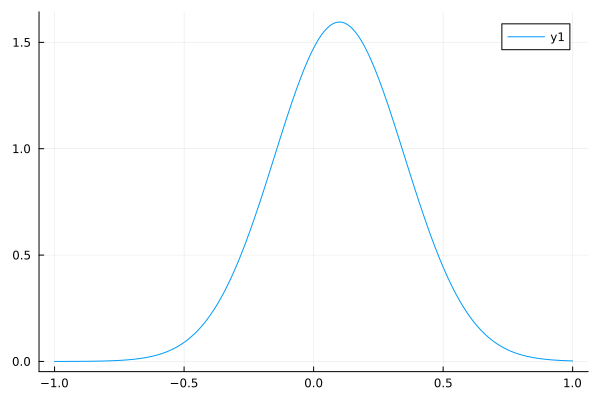

In [16]:
plot(x, pdf.(d, x)) # pdf(::Distribution, x) gives the pdf at x

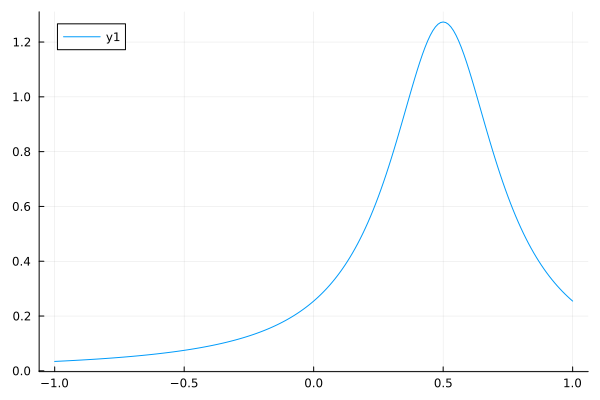

In [17]:
cauchy = Cauchy(0.5, 0.25)
plot(x, pdf.(cauchy, x))

You can also create your own distribution by extending a small amount of methods. 

Okay, so where are these distributions useful? Well, you can for example use `rand(::Distribution, ...)` and sample random numbers from an arbitrary distribution:

In [18]:
rand(cauchy)

0.5817345083340894

In [19]:
rand(cauchy, 10, 10)

10×10 Matrix{Float64}:
  0.999679   -0.135579    0.594629  …  0.390487   0.601175   0.448232
  0.797255    0.691408    0.922227     0.738807  -1.00989    0.543166
 -9.86093    -0.0316268   0.558948     0.610573   0.529326   2.3448
  0.898875  -11.0293      0.304647     0.211772   0.694113   0.499681
  0.492183   -0.145988    0.475942     0.107786   0.186608   1.21272
  0.352055    0.776011   -2.04297   …  0.547314   0.459296   0.322995
  0.671566    0.629599    0.477067     0.721899   0.330838   0.708399
  0.400699    1.33669     0.685215     0.386091   0.531552   0.494457
  0.37934     0.447952   -0.116007     0.904618   0.0491325  0.638882
  0.780056    0.449738    0.892225     0.425169   3.1957     1.43528

Or, you can use the `fit` function, to fit a distribution to an e.g. experimental measurement:

In [20]:
x = randn(5000);
fit(Normal, x)

Normal{Float64}(μ=0.015905736849361606, σ=1.0141155215069468)

In [21]:
cauchyfit = fit(Cauchy, x)

Cauchy{Float64}(μ=0.01281032325382463, σ=0.6930709921727323)

In [22]:
params(cauchyfit)

(0.01281032325382463, 0.6930709921727323)

Of course, other fundamental statistical measures, e.g. means, stds, quantiles, work out of the box for any distribution

In [23]:
quantile(cauchyfit, 0.5)

0.01281032325382463

In [24]:
quantile.(cauchyfit, [0.05, 0.95])

2-element Vector{Float64}:
 -4.363067703354098
  4.38868834986174

In [25]:
std(cauchyfit) # Cauchy distr. is known for NOT having finite std

NaN

# 4. Flux.jl

The go-to library for deep learning in Julia. Provides a clean and simple interface, easily extendible. The layers are defined as functions, making the pipeline very hackable.

Examples taken from the [sciml course](https://book.sciml.ai/notes/03-Introduction_to_Scientific_Machine_Learning_through_Physics-Informed_Neural_Networks/)

In [26]:
using Flux
NN2 = Chain(Dense(10 => 32,tanh),
           Dense(32 => 32,tanh),
           Dense(32 => 5))
NN2(rand(Float32, 10))

5-element Vector{Float32}:
 -0.5565024
  0.6077324
 -0.99831927
  0.2651569
  0.9282203

Not only the layers are just functions but the activation functions are also Julia functions! We can use any function that we like, and define it inline

In [27]:
NN3 = Chain(Dense(10 => 32,x->x^2),
            Dense(32 => 32,x->max(0,x)),
            Dense(32 => 5))
NN3(rand(10))

┌ Warning: Layer with Float32 parameters got Float64 input.
│   The input will be converted, but any earlier layers may be very slow.
│   layer = Dense(10 => 32, #11)
│   summary(x) = 10-element Vector{Float64}
└ @ Flux /home/francesco/.julia/packages/Flux/n3cOc/src/layers/stateless.jl:60


5-element Vector{Float32}:
 -0.04482215
  0.3690577
 -0.3329512
 -0.46615335
  0.12935263

Ok this seems all really neat, but how do you actually train a nn in Flux?

For example, let's say we wanted to make our neural network be the constant function 1 for any input x∈[0,1]10. We can then write the loss function:

In [28]:
NN = Chain(Dense(10 => 32,tanh),
           Dense(32 => 32,tanh),
           Dense(32 => 5))
loss() = sum(abs2,sum(abs2,NN(rand(10)).-1) for i in 1:100)
loss()

3462.3782f0

This loss function takes 100 random points in [0,1]10 and then computes the output of the neural network minus 1 on each of the values, and sums up the squared values (abs2). Why the squared values? This means that every computed loss value is positive, and so we know that by decreasing the loss this means that, on average our neural network outputs are closer to 1. What are the weights? Since we're using the Flux callable struct style from above, the weights are those inside of the NN chain object, which we can inspect:

In [29]:
NN[1].weight # The W matrix of the first layer

32×10 Matrix{Float32}:
 -0.33319      0.081127     0.354678   …  -0.341169   -0.0785718    0.232061
  0.105426    -0.0355558    0.295992      -0.0638376  -0.126062    -0.051958
  0.269277    -0.0589672    0.248089      -0.33992    -0.031429     0.320443
  0.28071     -0.372595     0.356532       0.0762635   0.227604    -0.0320146
  0.159856     0.119852     0.137049      -0.270632   -0.204567    -0.0918094
 -0.0944635    0.159513    -0.194737   …   0.229727    0.0357461    0.148695
 -0.219751     0.342882    -0.297049       0.151107    0.225312     0.367313
 -0.179792     0.0809781    0.225384      -0.2103      0.336762     0.231766
 -0.00988809  -0.367576     0.0327833      0.266554   -0.16643      0.109107
 -0.138081    -0.111682    -0.13811        0.0826722   0.192888    -0.141728
  ⋮                                    ⋱                           
 -0.039259    -0.297732    -0.337305       0.112969    0.00582955   0.217605
 -0.312522    -0.21425     -0.0876881      0.29956    -0.375

Now let's grab all of the parameters together:

In [30]:
p = Flux.params(NN)

Params([Float32[-0.33319038 0.08112698 … -0.078571804 0.23206098; 0.10542606 -0.035555776 … -0.12606207 -0.05195797; … ; -0.06861797 0.15468684 … 0.27452213 0.29790214; -0.19764207 -0.32267103 … -0.2022594 0.20269033], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.26491854 -0.29018557 … 0.02103779 -0.10823453; -0.27740586 -0.07786298 … 0.15644336 0.1878327; … ; 0.08582623 -0.13532166 … -0.12937632 0.113427974; 0.06543873 0.059563324 … -0.22282508 0.13883503], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[-0.3510716 -0.18150489 … -0.35610178 -0.3903631; -0.00436047 -0.08237507 … -0.11227694 0.33766222; … ; -0.110703826 0.22954662 … 0.19726573 -0.36587518; 0.16089705 0.14628984 … 0.08773337 0.17328444], Float32[0.0, 0.0, 0.0, 0.0, 0.0]])

That's a helper function on `Chain` which recursively gathers all of the defining parameters. Let's now find the optimal values `p` which cause the neural network to be the constant 1 function:

In [31]:
Flux.train!(loss, p, Iterators.repeated((), 10000), ADAM(0.1))

In [32]:
loss()

1.1713025f-6

## Solving ODEs with NNs

The process of solving a differential equation with a neural network, or using a differential equation as a regularizer in the loss function, is known as a physics-informed neural network, since this allows for physical equations to guide the training of the neural network in circumstances where data might be lacking.

Let us look at the ODE
$$
\begin{equation}
u' = cos(2 \pi t)
\end{equation}
$$
and approximate it with the neural network from a scalar to a scalar:

In [33]:
NNODE = Chain(x -> [x], # Take in a scalar and transform it into an array
           Dense(1 => 32,tanh),
           Dense(32 => 1),
           first) # Take first value, i.e. return a scalar
NNODE(1.0)

0.23771513f0

Instead of directly approximating the neural network, we will use the transformed equation that is forced to satisfy the boundary conditions. Using u0=1.0, we have the function:

In [34]:
g(t) = t*NNODE(t) + 1f0

g (generic function with 1 method)

we want to minimize the following

In [35]:
using Statistics
ϵ = sqrt(eps(Float32))
loss() = mean(abs2(((g(t+ϵ)-g(t))/ϵ) - cos(2π*t)) for t in 0:1f-2:1f0)

loss (generic function with 1 method)

In [36]:
opt = Flux.Descent(0.01)
data = Iterators.repeated((), 5000)
iter = 0
cb = function () #callback function to observe training
  global iter += 1
  if iter % 500 == 0
    display(loss())
  end
end
display(loss())
Flux.train!(loss, Flux.params(NNODE), data, opt; cb=cb)

0.5778769863119433

0.48873420382349786

0.440051637262582

0.27948168740285617

0.07081738447303247

0.021623587827038653

0.014512501334252359

0.011897027581614431

0.010811181456895046

0.010254521546066632

0.009887721951795792

Well did it work?

In [37]:
t = 0:0.001:1.0
plot(t,g.(t),label="NN")
plot!(t,1.0 .+ sin.(2π.*t)/2π, label = "True Solution")

## Something more standard

We want to code a mlp that deals with the fashionMNIST dataset. 

Example adapted from [this repo](https://github.com/owainkenwayucl/JuliaML/blob/main/Fashion/simple.jl)

Let's start by downloading some data

In [38]:
using Flux, MLDatasets
train_data = FashionMNIST(split=:train)

dataset FashionMNIST:
  metadata  =>    Dict{String, Any} with 4 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

Now we split it into images and categories

In [39]:
train_X, train_Y = train_data[:]

(features = [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], targets = [9, 0, 0, 3, 0, 2, 7, 2, 5, 5  …  4, 1, 7, 2, 8, 5, 1, 3, 0, 5])

After that we get the categories from the metadata

In [40]:
categories = train_data.metadata["class_names"]

10-element Vector{String}:
 "T-Shirt"
 "Trouser"
 "Pullover"
 "Dress"
 "Coat"
 "Sandal"
 "Shirt"
 "Sneaker"
 "Bag"
 "Ankle boot"

And we repack the category integers into probability matrix

In [41]:
train_Y = Flux.onehotbatch(train_Y, 0:9)

10×60000 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  1  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1  ⋅  ⋅  1  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅

It is now time to build our model! The input dimensions are 28x28 -> 784 and the output dimensions after one hot encoding are 10

In [42]:
model = Chain(
	Dense(784, 256, relu),
	Dense(256, 10, relu), softmax
)

Chain(
  Dense(784 => 256, relu),              # 200_960 parameters
  Dense(256 => 10, relu),               # 2_570 parameters
  NNlib.softmax,
)                   # Total: 4 arrays, 203_530 parameters, 795.289 KiB.

Now we define the loss function, choosing from the ones provided by the library by default. The optimizer is, of course, ADAM.

In [43]:
loss(x, y) = Flux.Losses.logitcrossentropy(model(x), y)
optimiser = ADAM(0.0001)

Adam(0.0001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

Now for the training

In [44]:
epochs = 100
parameters = Flux.params(model)
_train_data = [(Flux.flatten(train_X),Flux.flatten(train_Y))]

using ProgressMeter
@showprogress for epoch in 1:epochs
	Flux.train!(loss, parameters, _train_data, optimiser)
end

Progress:   2%|▉                                        |  ETA: 0:03:11

Progress:   3%|█▎                                       |  ETA: 0:02:35

Progress:   4%|█▋                                       |  ETA: 0:02:06

Progress:   5%|██                                       |  ETA: 0:01:49

Progress:   6%|██▌                                      |  ETA: 0:01:38

Progress:   7%|██▉                                      |  ETA: 0:01:29

Progress:   8%|███▎                                     |  ETA: 0:01:23

Progress:   9%|███▊                                     |  ETA: 0:01:18

Progress:  10%|████▏                                    |  ETA: 0:01:14

Progress:  11%|████▌                                    |  ETA: 0:01:10

Progress:  12%|████▉                                    |  ETA: 0:01:08

Progress:  13%|█████▍                                   |  ETA: 0:01:05

Progress:  14%|█████▊                                   |  ETA: 0:01:03

Progress:  15%|██████▏                                  |  ETA: 0:01:01

Progress:  16%|██████▌                                  |  ETA: 0:00:59

Progress:  17%|███████                                  |  ETA: 0:00:57

Progress:  18%|███████▍                                 |  ETA: 0:00:55

Progress:  19%|███████▊                                 |  ETA: 0:00:54

Progress:  20%|████████▎                                |  ETA: 0:00:53

Progress:  21%|████████▋                                |  ETA: 0:00:52

Progress:  22%|█████████                                |  ETA: 0:00:51

Progress:  23%|█████████▍                               |  ETA: 0:00:49

Progress:  24%|█████████▉                               |  ETA: 0:00:48

Progress:  25%|██████████▎                              |  ETA: 0:00:47

Progress:  26%|██████████▋                              |  ETA: 0:00:46

Progress:  27%|███████████▏                             |  ETA: 0:00:45

Progress:  28%|███████████▌                             |  ETA: 0:00:44

Progress:  29%|███████████▉                             |  ETA: 0:00:44

Progress:  30%|████████████▎                            |  ETA: 0:00:43

Progress:  31%|████████████▊                            |  ETA: 0:00:42

Progress:  32%|█████████████▏                           |  ETA: 0:00:41

Progress:  33%|█████████████▌                           |  ETA: 0:00:41

Progress:  34%|██████████████                           |  ETA: 0:00:40

Progress:  35%|██████████████▍                          |  ETA: 0:00:39

Progress:  36%|██████████████▊                          |  ETA: 0:00:38

Progress:  37%|███████████████▏                         |  ETA: 0:00:38

Progress:  38%|███████████████▋                         |  ETA: 0:00:37

Progress:  39%|████████████████                         |  ETA: 0:00:36

Progress:  40%|████████████████▍                        |  ETA: 0:00:36

Progress:  41%|████████████████▊                        |  ETA: 0:00:35

Progress:  42%|█████████████████▎                       |  ETA: 0:00:34

Progress:  43%|█████████████████▋                       |  ETA: 0:00:33

Progress:  44%|██████████████████                       |  ETA: 0:00:33

Progress:  45%|██████████████████▌                      |  ETA: 0:00:32

Progress:  46%|██████████████████▉                      |  ETA: 0:00:32

Progress:  47%|███████████████████▎                     |  ETA: 0:00:31

Progress:  48%|███████████████████▋                     |  ETA: 0:00:30

Progress:  49%|████████████████████▏                    |  ETA: 0:00:30

Progress:  50%|████████████████████▌                    |  ETA: 0:00:29

Progress:  51%|████████████████████▉                    |  ETA: 0:00:28

Progress:  52%|█████████████████████▍                   |  ETA: 0:00:28

Progress:  53%|█████████████████████▊                   |  ETA: 0:00:27

Progress:  54%|██████████████████████▏                  |  ETA: 0:00:27

Progress:  55%|██████████████████████▌                  |  ETA: 0:00:26

Progress:  56%|███████████████████████                  |  ETA: 0:00:25

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:25

Progress:  58%|███████████████████████▊                 |  ETA: 0:00:24

Progress:  59%|████████████████████████▎                |  ETA: 0:00:24

Progress:  60%|████████████████████████▋                |  ETA: 0:00:23

Progress:  61%|█████████████████████████                |  ETA: 0:00:22

Progress:  62%|█████████████████████████▍               |  ETA: 0:00:22

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:21

Progress:  64%|██████████████████████████▎              |  ETA: 0:00:21

Progress:  65%|██████████████████████████▋              |  ETA: 0:00:20

Progress:  66%|███████████████████████████              |  ETA: 0:00:19

Progress:  67%|███████████████████████████▌             |  ETA: 0:00:19

Progress:  68%|███████████████████████████▉             |  ETA: 0:00:18

Progress:  69%|████████████████████████████▎            |  ETA: 0:00:18

Progress:  70%|████████████████████████████▊            |  ETA: 0:00:18

Progress:  71%|█████████████████████████████▏           |  ETA: 0:00:17

Progress:  72%|█████████████████████████████▌           |  ETA: 0:00:17

Progress:  73%|█████████████████████████████▉           |  ETA: 0:00:16

Progress:  74%|██████████████████████████████▍          |  ETA: 0:00:15

Progress:  75%|██████████████████████████████▊          |  ETA: 0:00:15

Progress:  76%|███████████████████████████████▏         |  ETA: 0:00:14

Progress:  77%|███████████████████████████████▋         |  ETA: 0:00:14

Progress:  78%|████████████████████████████████         |  ETA: 0:00:13

Progress:  79%|████████████████████████████████▍        |  ETA: 0:00:12

Progress:  80%|████████████████████████████████▊        |  ETA: 0:00:12

Progress:  81%|█████████████████████████████████▎       |  ETA: 0:00:11

Progress:  82%|█████████████████████████████████▋       |  ETA: 0:00:11

Progress:  83%|██████████████████████████████████       |  ETA: 0:00:10

Progress:  84%|██████████████████████████████████▌      |  ETA: 0:00:09

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:09

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:08

Progress:  87%|███████████████████████████████████▋     |  ETA: 0:00:08

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:07

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:06

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:06

Progress:  91%|█████████████████████████████████████▎   |  ETA: 0:00:05

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:05

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:04

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:03

Progress:  95%|███████████████████████████████████████  |  ETA: 0:00:03

Progress:  96%|███████████████████████████████████████▍ |  ETA: 0:00:02

Progress:  97%|███████████████████████████████████████▊ |  ETA: 0:00:02

Progress:  98%|████████████████████████████████████████▏|  ETA: 0:00:01

Progress:  99%|████████████████████████████████████████▋|  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████| Time: 0:00:57


Now let's test the model: first download the training data

In [45]:
test_data = FashionMNIST(split=:test)
test_X, test_Y = test_data[:]
test_data_ = [(Flux.flatten(test_X), test_Y)]

1-element Vector{Tuple{Matrix{Float32}, Vector{Int64}}}:
 ([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [9, 2, 1, 1, 6, 1, 4, 6, 5, 7  …  5, 6, 8, 9, 1, 9, 1, 8, 1, 5])

And then we can look at the accuracy

In [46]:
a_sum_ = 0
for test in 1:length(test_Y)
	guess_ = findmax(model(test_data_[1][1][:, test]))[2]
	correct = test_Y[test] + 1 # off by one errors :(

	if guess_ == correct
		global a_sum_ = a_sum_ + 1
	end 
end
println("Accuracy: ", a_sum_ / length(test_Y))

Accuracy: 0.6169
